In [37]:
import numpy as np
import pickle
import math
from scipy.stats import sem
import matplotlib.pyplot as plt
import pandas as pd
import time
import pprint
import seaborn as sns
import statsmodels.formula.api as smf
import CMR_IA as cmr
import scipy as sp
sns.set_context('paper')
plt.style.use('default')
pd.set_option('display.max_columns', None)

In [38]:
with open("simu8_data/simu8_design.pkl", 'rb') as inp:
    df_study = pickle.load(inp)
    df_test = pickle.load(inp)
# df_study = df_study.loc[df_study.session < 1000]
# df_test = df_test.loc[df_test.session < 1000]

In [39]:
df_study

,study_itemno1,study_itemno2,study_item1,study_item2,serial_pos,list,session
0,12,24,Face12,Joe,0,0,0
1,2,29,Face2,Mark,1,0,0
2,6,27,Face6,Dan,2,0,0
3,13,18,Face13,John,3,0,0
4,11,31,Face11,George,4,0,0
...,...,...,...,...,...,...,...
79995,8,30,Face8,Mike,3,0,9999
79996,9,24,Face9,Joe,4,0,9999
79997,7,28,Face7,Paul,5,0,9999
79998,16,23,Face16,Charles,6,0,9999


In [40]:
df_test

,test_itemno,test_item,correct_ans,study_pos,list,session
0,1,Face1,30,6,0,0
1,2,Face2,29,1,0,0
2,6,Face6,27,2,0,0
3,14,Face14,22,7,0,0
4,13,Face13,18,3,0,0
...,...,...,...,...,...,...
79995,1,Face1,20,1,0,9999
79996,15,Face15,25,0,0,9999
79997,8,Face8,30,3,0,9999
79998,16,Face16,23,6,0,9999


In [41]:
def simu_cr_similarity(params):

    # load stimuli
    with open("simu8_data/simu8_design.pkl", 'rb') as inp:
        df_study = pickle.load(inp)
        df_test = pickle.load(inp)
    # df_study = df_study.loc[df_study.session < 1000]
    # df_test = df_test.loc[df_test.session < 1000]

    # load and get face distance
    face_distance = np.load('simu8_data/simu8_distance.npy')
    def get_distance(df_tmp):
        faces = np.unique(df_tmp.test_itemno)
        face_dist = {}
        for face in faces:
            this_dist = []
            for other_face in faces:
                if face != other_face:
                    this_dist.append(face_distance[face-1,other_face-1])
            this_dist = np.array(this_dist)
            face_dist[face] = this_dist
        y = df_tmp.apply(lambda x: face_dist[x['test_itemno']],axis=1)
        return y
    df_test['distance'] = df_test.groupby("session").apply(get_distance).to_frame(name='distance').reset_index()['distance']
    
    distance_thresh = 3  # need check
    df_test['neighbour'] = df_test.apply(lambda x: sum(x['distance'] < distance_thresh), axis=1)
    df_test['neighbour_group'] = df_test.apply(lambda x: 6 if x['neighbour'] == 7 else x['neighbour'], axis=1)

    # load semantic matrix
    s_mat = np.load('simu8_data/simu8_smat.npy')

    # run CMR
    df_simu, f_in, f_dif = cmr.run_norm_cr_multi_sess(params,df_study, df_test ,s_mat)
    df_simu = df_simu.merge(df_test,on=['session','list','test_itemno'])

    return df_simu

In [42]:
def anal_perform(df_simu):
    # get correction
    df_simu['correct'] = df_simu.s_resp == df_simu.correct_ans
    print("correct rate: ", sum(df_simu.correct)/len(df_simu.correct))

    # plt neighborhood effect (as paper)
    df_neighbour_group = df_simu.groupby("neighbour_group").correct.mean().reset_index()
    fig, ax = plt.subplots(figsize=(5,5))
    ax.spines[['right', 'top']].set_visible(False)
    ax.tick_params(axis="y",direction="in")
    ax.tick_params(axis="x",direction="in")
    sns.lineplot(data=df_neighbour_group.query("neighbour_group > 0"), x='neighbour_group', y='correct', linewidth=2, marker='o', markersize = 7)
    plt.ylim([0.4,1])
    plt.xlim([0.5,6.5])
    plt.xticks(ticks=np.arange(1,7), labels=['1','2','3','4','5','6-7'])
    plt.xlabel('Number of Neighbours')
    plt.ylabel('Probability of Correct Recall')
    plt.savefig('simu8_fig/simu8_correct_neighbourgroup.pdf')
    plt.show()

    # get ILI
    df_simu['ITI'] = df_simu.apply(lambda x: True if x['correct'] == False and 17 <= x['s_resp'] <= 32 else False, axis=1)
    df_ILI = df_simu.loc[df_simu.ITI == True,:].copy()
    
    # get distance between ILI and correct faces
    face_distance = np.load('simu8_data/simu8_distance.npy')
    with open("simu8_data/simu8_design.pkl", 'rb') as inp:
        df_study = pickle.load(inp)
    # df_study = df_study.loc[df_study.session < 1000]
    def get_resp_face(df_tmp):
        sess = np.unique(df_tmp.session).item()
        sess_name_face = df_study.query(f"session == {sess}")[["study_itemno1","study_itemno2"]].set_index("study_itemno2").to_dict()['study_itemno1']
        resp_face = df_tmp.apply(lambda x: sess_name_face[x['s_resp']],axis=1)
        return resp_face
    df_ILI['resp_face'] = df_ILI.groupby("session").apply(get_resp_face).to_frame().reset_index()[0].to_list()
    df_ILI['resp_corr_distance'] = df_ILI.apply(lambda x: face_distance[x['test_itemno']-1,x['resp_face']-1], axis=1)
    df_ILI['distance_bin'] = df_ILI.apply(lambda x: str(0.5 * (x['resp_corr_distance'] // 0.5 + 1)) if x['resp_corr_distance'] < 3.5 else ">3.5", axis=1)

    # count probability of ILI from all distance
    distance_cnt = {}
    for lst in df_ILI.distance:
        for d in lst:
            d_group = str(0.5 * (d // 0.5 + 1)) if d < 3.5 else ">3.5"
            if d_group in distance_cnt:
                distance_cnt[d_group] += 1
            else:
                distance_cnt[d_group] = 1
    df_ILI_distance = df_ILI.groupby("distance_bin")['test_itemno'].count().to_frame(name='ILI_cnt').reset_index()
    df_ILI_distance['ILI_poss'] = df_ILI_distance.apply(lambda x: distance_cnt[x['distance_bin']], axis=1)
    df_ILI_distance['ILI_prob'] = df_ILI_distance['ILI_cnt'] / df_ILI_distance['ILI_poss']

    # plot ILI by distance bin
    fig,ax = plt.subplots(figsize=(5,5))
    ax.spines[['right', 'top']].set_visible(False)
    ax.tick_params(axis="y",direction="in")
    ax.tick_params(axis="x",direction="in")
    sns.lineplot(data=df_ILI_distance, x='distance_bin', y='ILI_prob', linewidth=2, marker='o', markersize = 7)
    plt.ylim([0,0.25])
    plt.xlim([-1,6.5])
    plt.xlabel('Distance Bins')
    plt.ylabel('Probability of ILI')
    plt.savefig('simu8_fig/simu8_ILI_distance.pdf')
    plt.show()

    return df_neighbour_group, df_ILI_distance

### Run CMR-IA

In [43]:
params = cmr.make_default_params()
params.update(
    beta_enc = 0.5,
    beta_cue = 0.7, # overall accuracy important
    beta_distract = 0, 
    beta_rec_new = 0.1,
    beta_rec_post = 0.1,
    gamma_fc = 0.4,
    gamma_cf = 0.6, # unknown why
    s_fc = 0.4,
    c_thresh = 0.01,
    c_thresh_ass = 0.01,
    a = 2800,
    b = 2.14,
    m = 0,
    n = 1,
    kappa = 0.08,
    lamb = 0.04,
    eta = 0.01,
    alpha = 0.5,
    omega = 2,
    phi_s = 1,
    phi_d = 0.6,
    nitems_in_accumulator = 16, # must be 16
    d_ass = 0.6, # overall accuracy important
    No_recall = np.arange(0,8),
)
params

{'beta_enc': 0.5,
 'beta_rec': 0.5,
 'beta_cue': 0.7,
 'beta_rec_post': 0.1,
 'beta_distract': 0,
 'phi_s': 1,
 'phi_d': 0.6,
 's_cf': 0,
 's_fc': 0.4,
 'kappa': 0.08,
 'eta': 0.01,
 'omega': 2,
 'alpha': 0.5,
 'c_thresh': 0.01,
 'c_thresh_itm': 0.5,
 'c_thresh_ass': 0.01,
 'd_ass': 0.6,
 'lamb': 0.04,
 'rec_time_limit': 60000.0,
 'dt': 10,
 'nitems_in_accumulator': 16,
 'max_recalls': 50,
 'learn_while_retrieving': False,
 'a': 2800,
 'b': 2.14,
 'm': 0,
 'n': 1,
 'c1': 0,
 'thresh_sigma': 0,
 'No_recall': array([0, 1, 2, 3, 4, 5, 6, 7]),
 'var_enc': 1,
 'bad_enc_ratio': 1,
 'gamma_fc': 0.4,
 'gamma_cf': 0.6,
 'beta_rec_new': 0.1}

CMR2 Time: 95.17243456840515
correct rate:  0.6529875


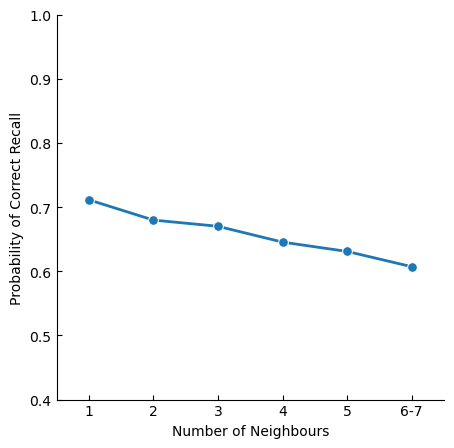

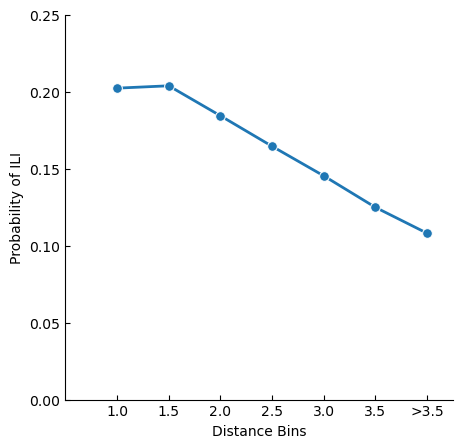

In [44]:
df_simu = simu_cr_similarity(params)
df_neighbour_group, df_ILI_distance = anal_perform(df_simu)

In [45]:
df_simu.head(16)

,list,session,test_itemno,s_resp,s_rt,csim,test_item,correct_ans,study_pos,distance,neighbour,neighbour_group,correct,ITI
0,0,0,1,30.0,1330.0,0.784201,Face1,30,6,"[1.0709, 2.202, 2.2233, 3.2373, 3.5772, 2.8095...",5,5,True,False
1,0,0,2,27.0,1960.0,0.427417,Face2,29,1,"[1.0709, 2.0108, 2.4045, 3.7211, 3.5024, 2.597...",5,5,False,True
2,0,0,6,18.0,1880.0,0.514806,Face6,27,2,"[2.202, 2.0108, 3.194, 2.8217, 3.9032, 1.6004,...",5,5,False,True
3,0,0,14,22.0,1290.0,0.719805,Face14,22,7,"[2.9509, 2.9187, 2.4855, 1.8175, 2.3944, 3.368...",6,6,True,False
4,0,0,13,31.0,1790.0,0.534239,Face13,18,3,"[2.8095, 2.5971, 1.6004, 2.5139, 2.5733, 3.678...",6,6,False,True
5,0,0,8,30.0,1890.0,0.574001,Face8,19,5,"[2.2233, 2.4045, 3.194, 3.0134, 2.9409, 2.5139...",5,5,False,True
6,0,0,12,19.0,1660.0,0.519958,Face12,24,0,"[3.5772, 3.5024, 3.9032, 2.9409, 3.2567, 3.678...",1,1,False,True
7,0,0,11,31.0,2610.0,0.749928,Face11,31,4,"[3.2373, 3.7211, 2.8217, 3.0134, 3.2567, 2.573...",3,3,True,False
8,0,1,12,25.0,1980.0,0.581597,Face12,25,1,"[2.8316, 3.6906, 3.9032, 1.1045, 2.2145, 3.256...",3,3,True,False
9,0,1,11,30.0,1390.0,0.714823,Face11,30,3,"[2.1194, 3.3819, 2.8217, 3.6998, 3.4185, 3.256...",3,3,True,False


In [46]:
df_ILI_distance

,distance_bin,ILI_cnt,ILI_poss,ILI_prob
0,1.0,707,3496,0.202231
1,1.5,2102,10316,0.203761
2,2.0,1854,10060,0.184294
3,2.5,6005,36509,0.164480
4,3.0,6602,45442,0.145284
5,3.5,6910,55356,0.124828
6,>3.5,3580,33141,0.108023


### Other Analysis

In [47]:
# correct rate
sum(df_simu.correct)/len(df_simu.correct)

0.6529875

In [48]:
df_neighbour_group = df_simu.groupby("neighbour_group").correct.mean().reset_index()
df_neighbour_group

,neighbour_group,correct
0,0,0.768559
1,1,0.711328
2,2,0.679743
3,3,0.670055
4,4,0.645385
5,5,0.630875
6,6,0.607103


In [49]:
df_neighbour = df_simu.groupby("neighbour").correct.mean().reset_index()
df_neighbour

,neighbour,correct
0,0,0.768559
1,1,0.711328
2,2,0.679743
3,3,0.670055
4,4,0.645385
5,5,0.630875
6,6,0.607827
7,7,0.599099


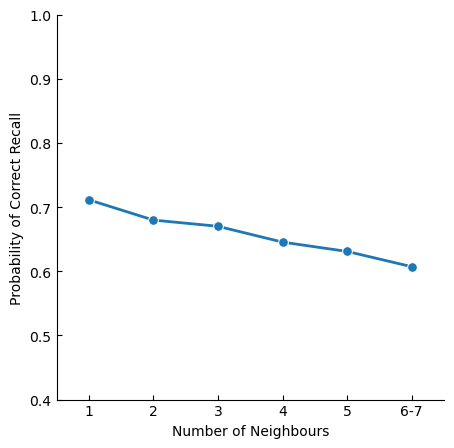

In [50]:
# neigbour group (as paper)
fig,ax = plt.subplots(figsize=(5,5))
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
sns.lineplot(data=df_neighbour_group.query("neighbour_group > 0"), x='neighbour_group', y='correct', linewidth=2, marker='o', markersize = 7)
plt.ylim([0.4,1])
plt.xlim([0.5,6.5])
plt.xticks(ticks=np.arange(1,7), labels=['1','2','3','4','5','6-7'])
plt.xlabel('Number of Neighbours')
plt.ylabel('Probability of Correct Recall')
# plt.savefig('fig/simu8_correct_neighbourgroup.pdf')
plt.show()

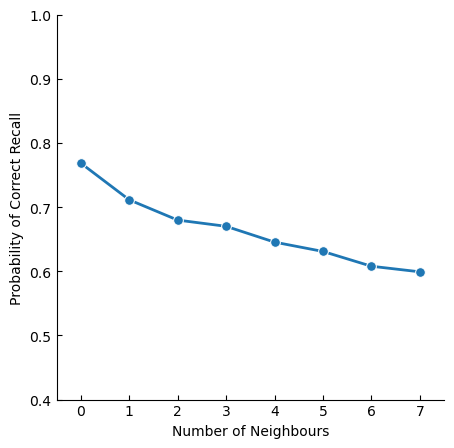

In [51]:
# neighbour
fig,ax = plt.subplots(figsize=(5,5))
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
sns.lineplot(data=df_neighbour, x='neighbour', y='correct', linewidth=2, marker='o', markersize = 7)
plt.ylim([0.4,1])
plt.xlim([-0.5,7.5])
plt.xlabel('Number of Neighbours')
plt.ylabel('Probability of Correct Recall')
# plt.savefig('fig/simu8_correct_neighbour.pdf')
plt.show()

In [52]:
df_ILI = df_simu.loc[df_simu.ITI == True,:].copy()
df_ILI

,list,session,test_itemno,s_resp,s_rt,csim,test_item,correct_ans,study_pos,distance,neighbour,neighbour_group,correct,ITI
1,0,0,2,27.0,1960.0,0.427417,Face2,29,1,"[1.0709, 2.0108, 2.4045, 3.7211, 3.5024, 2.597...",5,5,False,True
2,0,0,6,18.0,1880.0,0.514806,Face6,27,2,"[2.202, 2.0108, 3.194, 2.8217, 3.9032, 1.6004,...",5,5,False,True
4,0,0,13,31.0,1790.0,0.534239,Face13,18,3,"[2.8095, 2.5971, 1.6004, 2.5139, 2.5733, 3.678...",6,6,False,True
5,0,0,8,30.0,1890.0,0.574001,Face8,19,5,"[2.2233, 2.4045, 3.194, 3.0134, 2.9409, 2.5139...",5,5,False,True
6,0,0,12,19.0,1660.0,0.519958,Face12,24,0,"[3.5772, 3.5024, 3.9032, 2.9409, 3.2567, 3.678...",1,1,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79970,0,9996,5,23.0,1500.0,0.532660,Face5,19,3,"[2.0873, 3.4673, 0.9329, 3.2177, 3.4034, 3.690...",2,2,False,True
79981,0,9997,16,30.0,1660.0,0.415857,Face16,20,0,"[3.4535, 3.1521, 3.5463, 2.3605, 2.4857, 2.653...",4,4,False,True
79983,0,9997,4,32.0,2660.0,0.382045,Face4,30,2,"[1.2474, 3.4673, 2.367, 2.7036, 3.8481, 3.6034...",3,3,False,True
79994,0,9999,9,28.0,1680.0,0.558106,Face9,24,4,"[3.5825, 3.3268, 3.6394, 3.3644, 3.4755, 1.838...",2,2,False,True


In [53]:
df_ILI_neighbour = df_ILI.query("neighbour > 0").groupby("neighbour_group")['test_item'].count().to_frame(name='ILI_cnt').reset_index()
df_ILI_neighbour['neighbour_cnt'] = df_simu.groupby("neighbour_group")['test_item'].count()[1:].to_list()
df_ILI_neighbour['ILI_prob'] = df_ILI_neighbour['ILI_cnt'] / df_ILI_neighbour['neighbour_cnt']
df_ILI_neighbour

,neighbour_group,ILI_cnt,neighbour_cnt,ILI_prob
0,1,739,2560,0.288672
1,2,3184,9942,0.320257
2,3,6849,20758,0.329945
3,4,8786,24779,0.354574
4,5,6047,16382,0.369125
5,6,2102,5350,0.392897


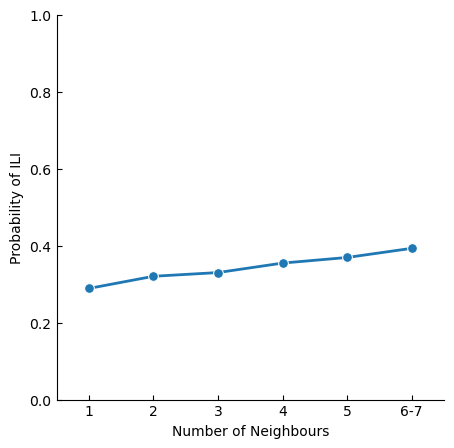

In [54]:
# ILI by neighbour
fig,ax = plt.subplots(figsize=(5,5))
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
sns.lineplot(data=df_ILI_neighbour.query("neighbour_group > 0"), x='neighbour_group', y='ILI_prob', linewidth=2, marker='o', markersize = 7)
plt.ylim([0,1])
plt.xlim([0.5,6.5])
plt.xticks(ticks=np.arange(1,7), labels=['1','2','3','4','5','6-7'])
plt.xlabel('Number of Neighbours')
plt.ylabel('Probability of ILI')
# plt.savefig('fig/simu8_ILI_neighbourgroup.pdf')
plt.show()